[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tabris2015/tensorflow-dogs-fastapi/blob/master/notebooks/dogs_transfer_learning.ipynb)

# Clasificación de razas de perros

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
# importando el dataset
IMG_SIZE = 224
batch_size = 32

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes
print(ds_info.features['label'].num_classes)


120


In [3]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

In [4]:
# One hot encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


In [5]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


In [6]:
# definicion del modelo
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Capas de aumentacion de datos
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

# Usando efficientnet como backbone
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Congelar pesos entrenados
    model.trainable = False

    # Reconstruir ultima capa con dimensiones adecuadas
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compilar
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


In [7]:
# entrenamiento
epochs = 40
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_local.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
        verbose=1),
]
model = build_model(num_classes=NUM_CLASSES)

hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, callbacks=callbacks)
plot_hist(hist)

16711680/16705208 [==============================] - 3s 0us/step
Epoch 1/40


KeyboardInterrupt: 

Epoch 1/30


375/375 [==============================] - 29s 70ms/step - loss: 1.4533 - accuracy: 0.6192 - val_loss: 0.8126 - val_accuracy: 0.7781

Epoch 00001: val_loss improved from inf to 0.81258, saving model to best_local_refined.h5
Epoch 2/30
375/375 [==============================] - 24s 65ms/step - loss: 1.1959 - accuracy: 0.6619 - val_loss: 0.8062 - val_accuracy: 0.7819

Epoch 00002: val_loss improved from 0.81258 to 0.80623, saving model to best_local_refined.h5
Epoch 3/30
375/375 [==============================] - 25s 66ms/step - loss: 1.0301 - accuracy: 0.7017 - val_loss: 0.7891 - val_accuracy: 0.7832

Epoch 00003: val_loss improved from 0.80623 to 0.78911, saving model to best_local_refined.h5
Epoch 4/30
375/375 [==============================] - 24s 65ms/step - loss: 0.9394 - accuracy: 0.7170 - val_loss: 0.7891 - val_accuracy: 0.7847

Epoch 00004: val_loss did not improve from 0.78911
Epoch 5/30
375/375 [==============================] - 25s 67ms/step - loss: 0.8725 - accuracy: 0.7420 

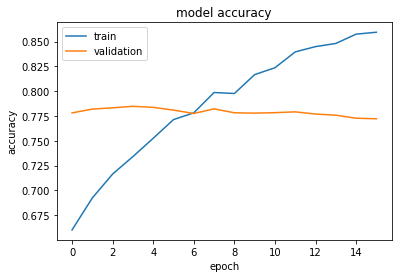

In [8]:
# Refinamiento descongelando capas
def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)
callbacks2 = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_local_refined.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1),
]
epochs = 30
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, callbacks=callbacks2)
plot_hist(hist)

## Probar modelo

In [7]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
BREED_FILE = 'breeds.txt'
MODEL_FILE = 'best_local_refined.h5'
IMG_SIZE = 224
n_top = 5

In [5]:
labels = []
with open(BREED_FILE, 'r') as f:
    for line in f:
        labels.append(line.strip())
        
loaded_model = tf.keras.models.load_model(MODEL_FILE)

{'chihuahua': 0.9977549910545349, 'mexican_hairless': 0.0015163009520620108, 'french_bulldog': 0.0003142647328786552, 'brabancon_griffon': 0.00027266607503406703, 'toy_terrier': 3.6511864891508594e-05}


([<matplotlib.axis.XTick at 0x7fb10610f0a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

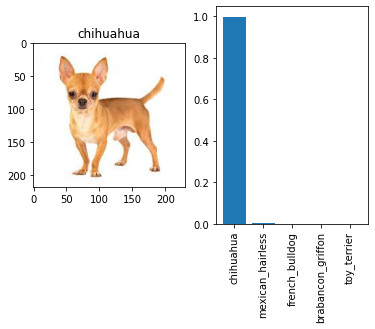

In [8]:
IMAGE_FILE = 'chihuahua.jpeg'

img = np.array(Image.open(IMAGE_FILE).resize((IMG_SIZE,IMG_SIZE)), dtype=np.float32)
pred = loaded_model.predict(img.reshape(-1, IMG_SIZE, IMG_SIZE, 3))
top_labels = {}
if len(labels) >= n_top:
    top_labels_ids = np.flip(np.argsort(pred, axis=1)[0, -n_top:])
    for label_id in top_labels_ids:
        top_labels[labels[label_id]] = pred[0,label_id].item()
pred_label = labels[np.argmax(pred)]
print(top_labels)
plt.subplot(1,2,1)
plt.imshow(Image.open(IMAGE_FILE))
plt.title(pred_label)
plt.subplot(1,2,2)
plt.bar(top_labels.keys(), top_labels.values())
plt.xticks(list(top_labels.keys()), rotation='vertical')